# Data preprocessing
it contains two large modules:
process X and process Y

In [1]:
# import arcpy
import numpy as np
import os, glob
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
arcpy.CheckExtension('ImageAnalyst')

'Available'

## process X
### X from sentinal 2 L2A data
#### check bands and resolutions, resample all bands to 10m
resolution 10m: band2(blue), band3(green), band4(red), band8(nir)<br>
need to be resampled to R10m: band5, band6, band7, band8A, band11, band12<br>
band1, band9, band10 are useless, only for correction
so the total num of bands is 10<br>
followed by ASTER band4-9 and Geo-physical data

#### calculate NDVI
set threshold as 0.3, band3 is red, band7 is NIR

#### layer number and rock type
| Layer | Rock |
|-------|------|
| 0     | Vegetation|
| 1     | Unkown Rocks|
| 2     | Carbonate_sediment|
| 3     | Dolerite|
| 4     | Feldspathic_sediment|
| 5     | Felsic_volcanic|
| 6     | Gneiss|
| 7     | Granite|
| 8     | Mafic_volcanic|
| 9     | Quartz_sediment|

## Export training data X, Y with tile of 256 x 256

#### split X and Y into tiles

In [3]:
from src.DeepRock.utils import split2Tiles

In [4]:
geo = arcpy.Raster(r'C:\Users\yuch\Documents\ArcGIS\Projects\mount_isa\mount_isa.gdb\GEO')

In [18]:
geo_min = []
geo_max = []
for i in range(geo.bandCount):
    geo_min.append(float(arcpy.GetRasterProperties_management(geo, 'MINIMUM', 'Band_{0}'.format(i+1)).getOutput(0)))
    geo_max.append(float(arcpy.GetRasterProperties_management(geo, 'MAXIMUM', 'Band_{0}'.format(i+1)).getOutput(0)))

In [24]:
# normalize input remote sensing data, and save as numpy array
block_id = 4
# read the raster block
raster = arcpy.Raster('C:/Users/yuch/Documents/ArcGIS/Projects/mount_isa/BLOCK{0}.tif'.format(block_id))
raster_num = arcpy.RasterToNumPyArray(raster)
# Sentinel 2A data divided by 10000., ASTER divided by 1000.
# geo data nomalized by (-min)/(max-min)
for i in range(10):
    raster_num[i,:,:] = raster_num[i,:,:] / 10000.
    
for i in range(10, 16):
    raster_num[i,:,:] = raster_num[i,:,:] / 1000.
    
for i in range(16, 29):
    raster_num[i,:,:] = (raster_num[i,:,:] - geo_min[i-16])/(geo_max[i-16] - geo_min[i-16])
    
np.save('./data/Blocks/block{0}'.format(block_id), raster_num)

In [25]:
# save labels as numpy array
for block_id in range(1, 5):
    # read the raster block
    raster = arcpy.Raster('C:/Users/yuch/Documents/ArcGIS/Projects/mount_isa/Labels_BLOCK{0}.tif'.format(block_id))
    raster_num = arcpy.RasterToNumPyArray(raster)

    np.save('./data/Blocks/labels_block{0}'.format(block_id), raster_num)

In [27]:
# use block 1, 3, 4 as train data
# and block 2 as test data
split2Tiles('./data/train/X/', np.load('./data/Blocks/block1.npy'), suffix='block1')
split2Tiles('./data/train/Y/', np.load('./data/Blocks/labels_block1.npy'), suffix='block1')
split2Tiles('./data/train/X/', np.load('./data/Blocks/block3.npy'), suffix='block3')
split2Tiles('./data/train/Y/', np.load('./data/Blocks/labels_block3.npy'), suffix='block3')
split2Tiles('./data/train/X/', np.load('./data/Blocks/block4.npy'), suffix='block4')
split2Tiles('./data/train/Y/', np.load('./data/Blocks/labels_block4.npy'), suffix='block4')
split2Tiles('./data/test/X/', np.load('./data/Blocks/block2.npy'), suffix='block2')
split2Tiles('./data/test/Y/', np.load('./data/Blocks/labels_block2.npy'), suffix='block2')

split into 336 tiles
split into 336 tiles
split into 420 tiles
split into 420 tiles
split into 340 tiles
split into 340 tiles
split into 294 tiles
split into 294 tiles


#### remove tile with bad boundary

In [2]:
from src.DeepRock.utils import remove_boundary

In [3]:
remove_boundary('./data/train/')
remove_boundary('./data/test/')

removing tiles with bad boundary
removing tiles with bad boundary


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


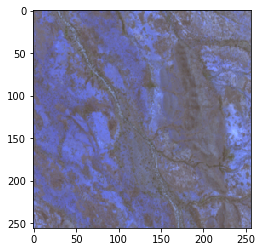

In [4]:
plt.imshow(4*np.transpose(np.load('./data/train/X/block1_196.npy')[0:3,:,:], (1,2,0)))

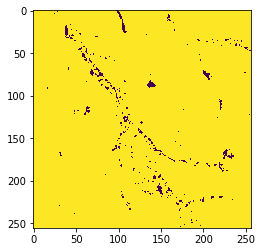

In [5]:
plt.imshow(np.argmax(np.load('./data/train/Y/block1_196.npy'), axis=0))